[dataset_builder] loaded. Available names:
['generate_preferred_directions', 'generate_direction_encoding_dataset']
=== Experiment 1: Static directions, T=800.0 ms, N=40 ===
Dataset shape (spikes): (800, 800, 40)
Saved temp dataset to: exp1_static_T800.npz

[Experiment 1] Linear decoder (rate)
X_train shape: (640, 40) X_test shape: (160, 40)
y_train distribution: {0: 80, 1: 80, 2: 80, 3: 80, 4: 80, 5: 80, 6: 80, 7: 80}
y_test  distribution: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20}
Logistic Regression train acc: 1.0000
Logistic Regression test  acc: 1.0000


c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


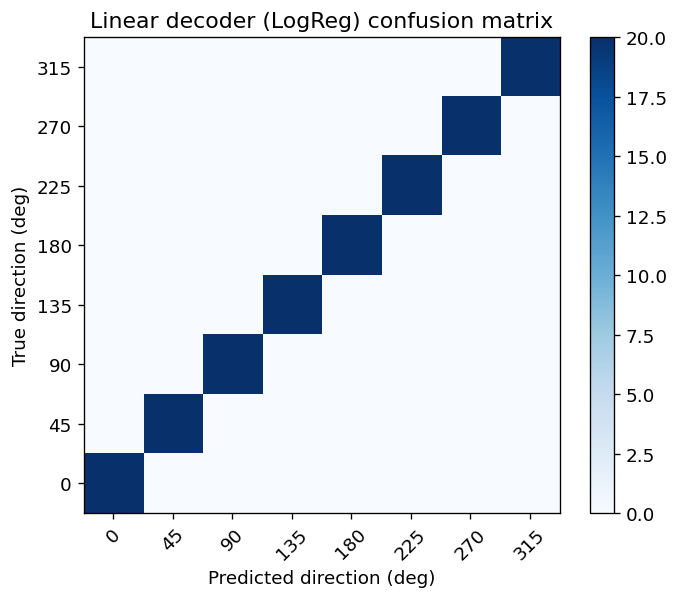


[Experiment 1] MLP decoder (rate)
Epoch   1 | loss 1.9058 | train acc 0.6891 | test acc 0.6687
Epoch   5 | loss 0.3313 | train acc 0.9984 | test acc 1.0000
Epoch  10 | loss 0.0337 | train acc 1.0000 | test acc 1.0000
Epoch  15 | loss 0.0143 | train acc 1.0000 | test acc 1.0000
Epoch  20 | loss 0.0082 | train acc 1.0000 | test acc 1.0000
Epoch  25 | loss 0.0052 | train acc 1.0000 | test acc 1.0000
Epoch  30 | loss 0.0037 | train acc 1.0000 | test acc 1.0000
Epoch  35 | loss 0.0027 | train acc 1.0000 | test acc 1.0000
Epoch  40 | loss 0.0021 | train acc 1.0000 | test acc 1.0000
Final MLP test accuracy: 1.0

[Experiment 1] SNN decoder (spike train)


KeyboardInterrupt: 

In [ ]:
# 公共导入 + 实验 1：静态方向 + 长时间窗（T=800ms）

import os
import numpy as np
import matplotlib.pyplot as plt

from encoding.dataset_builder import generate_direction_encoding_dataset
from decoding.linear_decoder import train_and_eval_linear
from decoding.rate_decoder_mlp import train_rate_mlp
from decoding.snn_decoder import train_snn_decoder

plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 11


# ===================== 实验 1：静态方向 + 长时间窗 =====================

def run_experiment_static_long_T(
    T_ms=800.0,
    n_neurons=40,
    trials_per_dir=100,
    seed=0,
    save_tmp=True,
    tmp_path="exp1_static_T800.npz",
    n_epochs_mlp=40,
    n_epochs_snn=40,
):
    """
    实验 1：静态 8 方向 + 长时间窗（T=800ms）
    - Linear / MLP：输入 spike count
    - SNN：输入完整 spike train
    """

    directions = np.arange(0, 360, 45)  # 8 个方向
    print(f"=== Experiment 1: Static directions, T={T_ms} ms, N={n_neurons} ===")

    # 1) 生成数据（中等噪声）
    dataset = generate_direction_encoding_dataset(
        directions_deg=directions,
        n_neurons=n_neurons,
        trials_per_dir=trials_per_dir,
        T=T_ms,
        dt=1.0,
        r_baseline=8.0,
        r_max_mean=25.0,
        r_max_std=6.0,
        tuning_sigma_deg=50.0,
        jitter_pref_deg=7.0,
        gain_sigma=0.25,
        shared_std=3.0,
        indep_std=2.0,
        seed=seed,
    )

    spikes = dataset["spikes"]
    labels = dataset["labels"]
    directions_deg = dataset["directions_deg"]

    print("Dataset shape (spikes):", spikes.shape)

    # 2) 保存临时数据集，兼容 decoding 模块
    if save_tmp:
        np.savez(
            tmp_path,
            spikes=spikes,
            labels=labels,
            directions_deg=directions_deg,
            meta=np.array([dataset["meta"]], dtype=object),
        )
        print("Saved temp dataset to:", tmp_path)
        dataset_path = tmp_path
    else:
        # 如果不保存，就直接写一个内存 npz 的替代接口（这里简单起见直接保存）
        raise NotImplementedError("建议保存成 npz 再用解码器")

    # 3) Linear 解码
    print("\n[Experiment 1] Linear decoder (rate)")
    _, (train_acc_lin, test_acc_lin) = train_and_eval_linear(
        dataset_path=dataset_path,
        test_size=0.2,
        random_state=0,
    )

    # 4) MLP 解码
    print("\n[Experiment 1] MLP decoder (rate)")
    _, (test_acc_mlp, _) = train_rate_mlp(
        dataset_path=dataset_path,
        test_size=0.2,
        random_state=0,
        n_epochs=n_epochs_mlp,
    )

    # 5) SNN 解码
    print("\n[Experiment 1] SNN decoder (spike train)")
    _, (test_acc_snn, _) = train_snn_decoder(
        dataset_path=dataset_path,
        test_size=0.2,
        random_state=0,
        n_epochs=n_epochs_snn,
    )

    # 6) 小总结条形图
    methods = ["Linear", "MLP (rate)", "SNN (spike)"]
    accs = [test_acc_lin, test_acc_mlp, test_acc_snn]

    plt.figure(figsize=(5, 4))
    plt.bar(methods, accs)
    plt.ylim(0, 1.05)
    plt.ylabel("Test accuracy")
    plt.title(f"Experiment 1: Static directions, T={T_ms} ms")
    for i, a in enumerate(accs):
        plt.text(i, a + 0.02, f"{a:.2f}", ha="center")
    plt.tight_layout()
    plt.show()

    return {
        "test_acc_lin": test_acc_lin,
        "test_acc_mlp": test_acc_mlp,
        "test_acc_snn": test_acc_snn,
    }


# 直接运行实验 1
results_exp1 = run_experiment_static_long_T()
results_exp1


=== Experiment 2: Two-segment stimulus, T1=100.0 ms, T2=100.0 ms, N=40 ===
Dataset shape (spikes): (1600, 200, 40)
Saved temp dataset to: exp2_two_segment_T100_100.npz

[Experiment 2] Linear decoder (whole-window rate)
X_train shape: (1280, 40) X_test shape: (320, 40)
y_train distribution: {0: 162, 1: 160, 2: 152, 3: 150, 4: 171, 5: 154, 6: 159, 7: 172}
y_test  distribution: {0: 40, 1: 40, 2: 38, 3: 37, 4: 43, 5: 39, 6: 40, 7: 43}


c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.5242
Logistic Regression test  acc: 0.3875


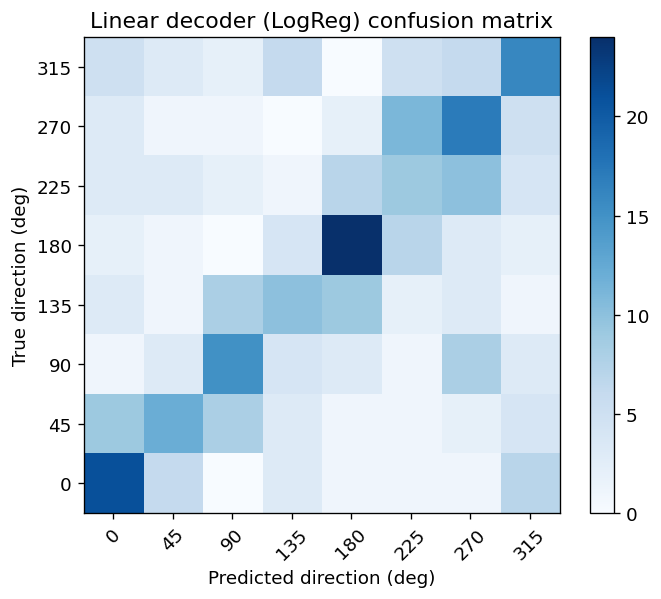


[Experiment 2] MLP decoder (whole-window rate)
Epoch   1 | loss 1.9804 | train acc 0.3383 | test acc 0.2844
Epoch   5 | loss 1.3744 | train acc 0.4711 | test acc 0.3937
Epoch  10 | loss 1.1853 | train acc 0.5820 | test acc 0.4437
Epoch  15 | loss 1.0535 | train acc 0.6398 | test acc 0.4281
Epoch  20 | loss 0.9198 | train acc 0.6930 | test acc 0.4125
Epoch  25 | loss 0.7861 | train acc 0.7461 | test acc 0.3906
Epoch  30 | loss 0.6490 | train acc 0.8164 | test acc 0.4188
Epoch  35 | loss 0.5185 | train acc 0.8711 | test acc 0.4125
Epoch  40 | loss 0.4016 | train acc 0.9141 | test acc 0.4000
Final MLP test accuracy: 0.4

[Experiment 2] SNN decoder (spike train, time-structure)
Epoch   1 | loss 5.5270 | train acc 0.1688 | test acc 0.1344
Epoch   5 | loss 1.5648 | train acc 0.3844 | test acc 0.3719
Epoch  10 | loss 1.3834 | train acc 0.4805 | test acc 0.4031
Epoch  15 | loss 1.2364 | train acc 0.5320 | test acc 0.4031
Epoch  20 | loss 1.1666 | train acc 0.5430 | test acc 0.4344
Epoch  25 |

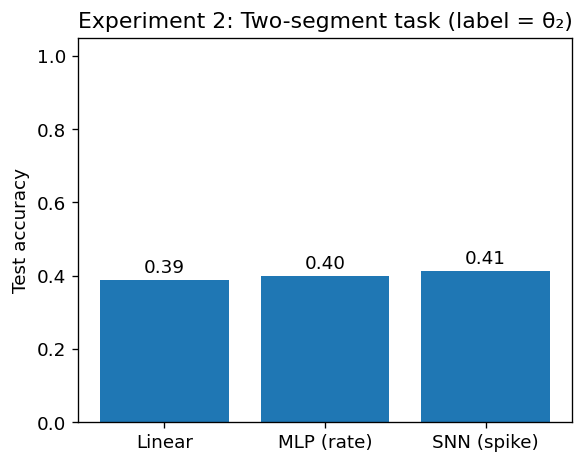

{'test_acc_lin': 0.3875, 'test_acc_mlp': 0.4, 'test_acc_snn': 0.4125}

In [ ]:
# ==== 实验 Notebook - 代码块 2 ====
# 实验 2：短时间窗 + 方向快速变化（两段不同方向，标签为后半段方向）

from encoding.tuning import (
    generate_preferred_directions,
    sample_r_max,
    direction_tuning_gaussian,
)
from encoding.poisson_spike import poisson_population_spikes


def generate_two_segment_direction_dataset(
    directions_deg,
    n_neurons=40,
    trials_total=800,
    T1=100.0,
    T2=100.0,
    dt=1.0,
    r_baseline=8.0,
    r_max_mean=25.0,
    r_max_std=6.0,
    tuning_sigma_deg=50.0,
    jitter_pref_deg=7.0,
    gain_sigma=0.25,
    shared_std=3.0,
    indep_std=2.0,
    seed=123,
):
    """
    生成“前后两段不同方向”的时间相关数据集。

    每个 trial：
    - 前 T1 ms：方向 theta1
    - 后 T2 ms：方向 theta2
    - 标签：theta2 对应的方向类别 idx

    返回：
    - spikes : (n_examples, T_steps_total, n_neurons)
    - labels : (n_examples,)
    - directions_deg : (n_dirs,)
    """
    rng = np.random.default_rng(seed)
    directions_deg = np.asarray(directions_deg)
    n_dirs = directions_deg.shape[0]
    T1_steps = int(T1 / dt)
    T2_steps = int(T2 / dt)
    T_steps_total = T1_steps + T2_steps

    # Population 参数
    theta_prefs = generate_preferred_directions(
        n_neurons=n_neurons,
        jitter_deg=jitter_pref_deg,
        seed=rng.integers(1_000_000_000),
    )
    r_max = sample_r_max(
        n_neurons=n_neurons,
        r_max_mean=r_max_mean,
        r_max_std=r_max_std,
        min_rate=1.0,
        max_rate=None,
        seed=rng.integers(1_000_000_000),
    )

    # 预先算好 tuning
    base_rates_all = direction_tuning_gaussian(
        theta_stim_deg=directions_deg,
        theta_pref_deg=theta_prefs,
        r_baseline=r_baseline,
        r_max=r_max,
        sigma_deg=tuning_sigma_deg,
    )  # (n_dirs, n_neurons)

    spikes = np.zeros((trials_total, T_steps_total, n_neurons), dtype=np.uint8)
    labels = np.zeros(trials_total, dtype=np.int64)
    theta1_idx_all = rng.integers(low=0, high=n_dirs, size=trials_total)
    theta2_idx_all = rng.integers(low=0, high=n_dirs, size=trials_total)

    for i in range(trials_total):
        d1_idx = theta1_idx_all[i]
        d2_idx = theta2_idx_all[i]

        rates1 = base_rates_all[d1_idx].copy()
        rates2 = base_rates_all[d2_idx].copy()

        # trial-by-trial 噪声我们分别对两个段加（也可以只在整个 trial 上加一次）
        def apply_noise(rates_segment):
            rates = rates_segment.copy()
            if gain_sigma > 0.0:
                gain = rng.lognormal(mean=0.0, sigma=gain_sigma)
                rates *= gain
            if shared_std > 0.0:
                rates += rng.normal(0.0, shared_std)
            if indep_std > 0.0:
                rates += rng.normal(0.0, indep_std, size=n_neurons)
            return np.clip(rates, 0.0, None)

        rates1_noisy = apply_noise(rates1)
        rates2_noisy = apply_noise(rates2)

        spikes1 = poisson_population_spikes(
            rates_hz=rates1_noisy,
            T=T1,
            dt=dt,
            rng=rng,
        )  # (T1_steps, n_neurons)
        spikes2 = poisson_population_spikes(
            rates_hz=rates2_noisy,
            T=T2,
            dt=dt,
            rng=rng,
        )  # (T2_steps, n_neurons)

        spikes[i, :T1_steps] = spikes1
        spikes[i, T1_steps:] = spikes2
        labels[i] = d2_idx  # 标签 = 后半段方向

    meta = {
        "T_total": T1 + T2,
        "T1": T1,
        "T2": T2,
        "dt": dt,
        "r_baseline": r_baseline,
        "r_max_mean": r_max_mean,
        "r_max_std": r_max_std,
        "tuning_sigma_deg": tuning_sigma_deg,
        "jitter_pref_deg": jitter_pref_deg,
        "gain_sigma": gain_sigma,
        "shared_std": shared_std,
        "indep_std": indep_std,
        "n_neurons": n_neurons,
        "trials_total": trials_total,
        "seed": seed,
        "task": "decode_second_segment_direction",
    }

    return {
        "spikes": spikes,
        "labels": labels,
        "directions_deg": directions_deg,
        "theta_prefs": theta_prefs,
        "r_max": r_max,
        "meta": meta,
    }


def run_experiment_two_segment(
    T1=100.0,
    T2=100.0,
    n_neurons=40,
    trials_total=1600,
    seed=1,
    tmp_path="exp2_two_segment_T100_100.npz",
    n_epochs_mlp=40,
    n_epochs_snn=40,
):
    """
    实验 2：短时间窗 + 方向快速变化（两段不同方向，标签为后半段方向）
    """

    directions = np.arange(0, 360, 45)
    print(
        f"=== Experiment 2: Two-segment stimulus, "
        f"T1={T1} ms, T2={T2} ms, N={n_neurons} ==="
    )

    dataset = generate_two_segment_direction_dataset(
        directions_deg=directions,
        n_neurons=n_neurons,
        trials_total=trials_total,
        T1=T1,
        T2=T2,
        dt=1.0,
        seed=seed,
    )

    spikes = dataset["spikes"]
    labels = dataset["labels"]
    directions_deg = dataset["directions_deg"]
    print("Dataset shape (spikes):", spikes.shape)

    np.savez(
        tmp_path,
        spikes=spikes,
        labels=labels,
        directions_deg=directions_deg,
        meta=np.array([dataset["meta"]], dtype=object),
    )
    print("Saved temp dataset to:", tmp_path)

    # 1) Linear 解码（rate+whole-window）
    print("\n[Experiment 2] Linear decoder (whole-window rate)")
    _, (train_acc_lin, test_acc_lin) = train_and_eval_linear(
        dataset_path=tmp_path,
        test_size=0.2,
        random_state=0,
    )

    # 2) MLP 解码
    print("\n[Experiment 2] MLP decoder (whole-window rate)")
    _, (test_acc_mlp, _) = train_rate_mlp(
        dataset_path=tmp_path,
        test_size=0.2,
        random_state=0,
        n_epochs=n_epochs_mlp,
    )

    # 3) SNN 解码（完整 spike train，能利用时间结构）
    print("\n[Experiment 2] SNN decoder (spike train, time-structure)")
    _, (test_acc_snn, _) = train_snn_decoder(
        dataset_path=tmp_path,
        test_size=0.2,
        random_state=0,
        n_epochs=n_epochs_snn,
    )

    methods = ["Linear", "MLP (rate)", "SNN (spike)"]
    accs = [test_acc_lin, test_acc_mlp, test_acc_snn]

    plt.figure(figsize=(5, 4))
    plt.bar(methods, accs)
    plt.ylim(0, 1.05)
    plt.ylabel("Test accuracy")
    plt.title(f"Experiment 2: Two-segment task (label = θ₂)")
    for i, a in enumerate(accs):
        plt.text(i, a + 0.02, f"{a:.2f}", ha="center")
    plt.tight_layout()
    plt.show()

    return {
        "test_acc_lin": test_acc_lin,
        "test_acc_mlp": test_acc_mlp,
        "test_acc_snn": test_acc_snn,
    }


# 直接运行实验 2
results_exp2 = run_experiment_two_segment()
results_exp2


In [ ]:
# ==== 实验 Notebook - 代码块 3 ====
# 实验 3：population size / tuning width / 噪声强度 sweep

def sweep_population_size(
    N_list=(10, 20, 40, 80),
    T_ms=400.0,
    trials_per_dir=100,
    base_seed=100,
    n_epochs_mlp=30,
    n_epochs_snn=30,
):
    directions = np.arange(0, 360, 45)
    acc_lin, acc_mlp, acc_snn = [], [], []

    for i, N in enumerate(N_list):
        print("\n" + "=" * 60)
        print(f"[Sweep N] N_neurons = {N}")
        print("=" * 60)

        dataset = generate_direction_encoding_dataset(
            directions_deg=directions,
            n_neurons=N,
            trials_per_dir=trials_per_dir,
            T=T_ms,
            dt=1.0,
            r_baseline=8.0,
            r_max_mean=25.0,
            r_max_std=6.0,
            tuning_sigma_deg=50.0,
            jitter_pref_deg=7.0,
            gain_sigma=0.25,
            shared_std=3.0,
            indep_std=2.0,
            seed=base_seed + i,
        )
        spikes, labels, directions_deg = (
            dataset["spikes"],
            dataset["labels"],
            dataset["directions_deg"],
        )
        tmp_path = f"tmp_sweep_N_{N}.npz"
        np.savez(
            tmp_path,
            spikes=spikes,
            labels=labels,
            directions_deg=directions_deg,
            meta=np.array([dataset["meta"]], dtype=object),
        )

        # Linear
        _, (_, test_acc_lin) = train_and_eval_linear(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
        )
        acc_lin.append(test_acc_lin)

        # MLP
        _, (test_acc_mlp, _) = train_rate_mlp(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_mlp,
        )
        acc_mlp.append(test_acc_mlp)

        # SNN
        _, (test_acc_snn, _) = train_snn_decoder(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_snn,
        )
        acc_snn.append(test_acc_snn)

        os.remove(tmp_path)

    N_arr = np.array(N_list, dtype=int)
    return N_arr, np.array(acc_lin), np.array(acc_mlp), np.array(acc_snn)


def sweep_tuning_sigma(
    sigma_list=(30.0, 45.0, 60.0),
    T_ms=400.0,
    n_neurons=40,
    trials_per_dir=100,
    base_seed=200,
    n_epochs_mlp=30,
    n_epochs_snn=30,
):
    directions = np.arange(0, 360, 45)
    acc_lin, acc_mlp, acc_snn = [], [], []

    for i, sigma in enumerate(sigma_list):
        print("\n" + "=" * 60)
        print(f"[Sweep sigma] sigma = {sigma} deg")
        print("=" * 60)

        dataset = generate_direction_encoding_dataset(
            directions_deg=directions,
            n_neurons=n_neurons,
            trials_per_dir=trials_per_dir,
            T=T_ms,
            dt=1.0,
            r_baseline=8.0,
            r_max_mean=25.0,
            r_max_std=6.0,
            tuning_sigma_deg=sigma,
            jitter_pref_deg=7.0,
            gain_sigma=0.25,
            shared_std=3.0,
            indep_std=2.0,
            seed=base_seed + i,
        )
        spikes, labels, directions_deg = (
            dataset["spikes"],
            dataset["labels"],
            dataset["directions_deg"],
        )
        tmp_path = f"tmp_sweep_sigma_{int(sigma)}.npz"
        np.savez(
            tmp_path,
            spikes=spikes,
            labels=labels,
            directions_deg=directions_deg,
            meta=np.array([dataset["meta"]], dtype=object),
        )

        # Linear
        _, (_, test_acc_lin) = train_and_eval_linear(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
        )
        acc_lin.append(test_acc_lin)

        # MLP
        _, (test_acc_mlp, _) = train_rate_mlp(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_mlp,
        )
        acc_mlp.append(test_acc_mlp)

        # SNN
        _, (test_acc_snn, _) = train_snn_decoder(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_snn,
        )
        acc_snn.append(test_acc_snn)

        os.remove(tmp_path)

    sigma_arr = np.array(sigma_list, dtype=float)
    return sigma_arr, np.array(acc_lin), np.array(acc_mlp), np.array(acc_snn)


def sweep_noise_level(
    noise_levels=(0.0, 0.2, 0.4),
    T_ms=400.0,
    n_neurons=40,
    trials_per_dir=100,
    base_seed=300,
    n_epochs_mlp=30,
    n_epochs_snn=30,
):
    """
    用一个 noise_level 统一 scale 三种噪声：
    gain_sigma = noise_level
    shared_std = 3.0 * noise_level
    indep_std  = 2.0 * noise_level
    """
    directions = np.arange(0, 360, 45)
    acc_lin, acc_mlp, acc_snn = [], [], []

    for i, nl in enumerate(noise_levels):
        print("\n" + "=" * 60)
        print(f"[Sweep noise] noise_level = {nl}")
        print("=" * 60)

        dataset = generate_direction_encoding_dataset(
            directions_deg=directions,
            n_neurons=n_neurons,
            trials_per_dir=trials_per_dir,
            T=T_ms,
            dt=1.0,
            r_baseline=8.0,
            r_max_mean=25.0,
            r_max_std=6.0,
            tuning_sigma_deg=50.0,
            jitter_pref_deg=7.0,
            gain_sigma=nl,
            shared_std=3.0 * nl,
            indep_std=2.0 * nl,
            seed=base_seed + i,
        )
        spikes, labels, directions_deg = (
            dataset["spikes"],
            dataset["labels"],
            dataset["directions_deg"],
        )
        tmp_path = f"tmp_sweep_noise_{nl:.1f}.npz"
        np.savez(
            tmp_path,
            spikes=spikes,
            labels=labels,
            directions_deg=directions_deg,
            meta=np.array([dataset["meta"]], dtype=object),
        )

        # Linear
        _, (_, test_acc_lin) = train_and_eval_linear(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
        )
        acc_lin.append(test_acc_lin)

        # MLP
        _, (test_acc_mlp, _) = train_rate_mlp(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_mlp,
        )
        acc_mlp.append(test_acc_mlp)

        # SNN
        _, (test_acc_snn, _) = train_snn_decoder(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_snn,
        )
        acc_snn.append(test_acc_snn)

        os.remove(tmp_path)

    nl_arr = np.array(noise_levels, dtype=float)
    return nl_arr, np.array(acc_lin), np.array(acc_mlp), np.array(acc_snn)


# === 实验 3：统一跑完三组 sweep 并画图 ===

N_arr, accN_lin, accN_mlp, accN_snn = sweep_population_size()
sigma_arr, accS_lin, accS_mlp, accS_snn = sweep_tuning_sigma()
nl_arr, accNoise_lin, accNoise_mlp, accNoise_snn = sweep_noise_level()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1) Accuracy vs N
ax = axes[0]
ax.plot(N_arr, accN_lin,  marker="o", linestyle="-",  label="Linear")
ax.plot(N_arr, accN_mlp,  marker="s", linestyle="--", label="MLP (rate)")
ax.plot(N_arr, accN_snn,  marker="D", linestyle="-.", label="SNN (spike)")
ax.set_xlabel("Number of neurons (N)")
ax.set_ylabel("Test accuracy")
ax.set_title("Population size sweep")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
ax.legend()

# 2) Accuracy vs sigma
ax = axes[1]
ax.plot(sigma_arr, accS_lin,  marker="o", linestyle="-",  label="Linear")
ax.plot(sigma_arr, accS_mlp,  marker="s", linestyle="--", label="MLP (rate)")
ax.plot(sigma_arr, accS_snn,  marker="D", linestyle="-.", label="SNN (spike)")
ax.set_xlabel("Tuning width σ (deg)")
ax.set_title("Tuning width sweep")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

# 3) Accuracy vs noise level
ax = axes[2]
ax.plot(nl_arr, accNoise_lin,  marker="o", linestyle="-",  label="Linear")
ax.plot(nl_arr, accNoise_mlp,  marker="s", linestyle="--", label="MLP (rate)")
ax.plot(nl_arr, accNoise_snn,  marker="D", linestyle="-.", label="SNN (spike)")
ax.set_xlabel("Noise level (relative)")
ax.set_title("Noise sweep")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [1]:
import numpy as np

def add_gaussian_noise_to_spikes(npz_in, npz_out, noise_sigma=0.1, clip=True, seed=0):
    rng = np.random.default_rng(seed)
    
    data = np.load(npz_in, allow_pickle=True)
    
    spikes = data["spikes"].astype(np.float32)
    spikecounts = data["spikecounts"]
    labels = data["labels"]
    directions_deg = data["directions_deg"]
    session_idx = data.get("session_idx")
    meta = data["meta"]

    print("Original spikes shape:", spikes.shape)

    # --- Add Gaussian noise ---
    noise = rng.normal(loc=0.0, scale=noise_sigma, size=spikes.shape)
    spikes_noisy = spikes + noise

    if clip:
        spikes_noisy = np.clip(spikes_noisy, 0.0, 1.0)

    np.savez(
        npz_out,
        spikes=spikes_noisy,
        spikecounts=spikecounts,
        labels=labels,
        directions_deg=directions_deg,
        session_idx=session_idx,
        meta=meta
    )

    print(f"[OK] Saved noisy dataset → {npz_out}")


In [ ]:

# 需要你已经实现好：
#   - decoding/linear_decoder.py   中的 train_and_eval_linear
#   - decoding/rate_decoder_mlp.py 中的 train_rate_mlp
#   - decoding/snn_decoder.py      中的 train_snn_decoder

import os
import numpy as np
import matplotlib.pyplot as plt

from decoding.linear_decoder import train_and_eval_linear
from decoding.rate_decoder_mlp import train_rate_mlp
from decoding.snn_decoder import train_snn_decoder

# ---------- 配置部分 ----------
# 存放 per-session npz 的目录
base_dir = r"D:\Neuron Science\FinPro\npz_data"   # 改成你自己的路径
# session 范围：0 ~ 21
session_ids = list(range(22))
# 训练集划分比例 & 随机种子
test_size = 0.2
random_state = 0

# MLP / SNN 的训练 epoch（可以根据实际速度调小/调大）
mlp_epochs = 40
snn_epochs = 40

# ---------- 存结果 ----------
linear_accs = []
mlp_accs = []
snn_accs = []
used_sessions = []  # 实际成功跑到的 session id

# ---------- 主循环：逐 session 做实验 ----------
for sid in session_ids:
    fname = f"HenryKohn2022_distractorseparation_session{sid}_v4.npz"
    dataset_path = os.path.join(base_dir, fname)

    if not os.path.exists(dataset_path):
        print(f"[Session {sid}] 文件不存在，跳过: {dataset_path}")
        continue

    print(f"\n================ Session {sid} ================")
    print(f"加载数据: {dataset_path}")

    # ----- Linear (rate-based baseline) -----
    try:
        _, (train_acc_lin, test_acc_lin) = train_and_eval_linear(
            dataset_path=dataset_path,
            test_size=test_size,
            random_state=random_state,
        )
        print(f"[Session {sid}] Linear   test acc = {test_acc_lin:.4f}")
    except Exception as e:
        print(f"[Session {sid}] Linear 训练/测试出错：{e}")
        test_acc_lin = np.nan

    # ----- MLP (rate-based) -----
    try:
        _, (test_acc_mlp, _) = train_rate_mlp(
            dataset_path=dataset_path,
            test_size=test_size,
            random_state=random_state,
            n_epochs=mlp_epochs,
        )
        print(f"[Session {sid}] MLP      test acc = {test_acc_mlp:.4f}")
    except Exception as e:
        print(f"[Session {sid}] MLP 训练/测试出错：{e}")
        test_acc_mlp = np.nan

    # ----- SNN (spike-train based) -----
    try:
        _, (test_acc_snn, _) = train_snn_decoder(
            dataset_path=dataset_path,
            test_size=test_size,
            random_state=random_state,
            n_epochs=snn_epochs,
        )
        print(f"[Session {sid}] SNN      test acc = {test_acc_snn:.4f}")
    except Exception as e:
        print(f"[Session {sid}] SNN 训练/测试出错：{e}")
        test_acc_snn = np.nan

    used_sessions.append(sid)
    linear_accs.append(test_acc_lin)
    mlp_accs.append(test_acc_mlp)
    snn_accs.append(test_acc_snn)

# ---------- 汇总为 numpy 数组 ----------
used_sessions = np.array(used_sessions)
linear_accs = np.array(linear_accs, dtype=float)
mlp_accs = np.array(mlp_accs, dtype=float)
snn_accs = np.array(snn_accs, dtype=float)

print("\n========== 总结 ==========")
for sid, la, ma, sa in zip(used_sessions, linear_accs, mlp_accs, snn_accs):
    print(f"Session {sid:2d} | Linear: {la:.4f} | MLP: {ma:.4f} | SNN: {sa:.4f}")

# ---------- 画图 ----------
plt.figure(figsize=(8, 5))
plt.plot(used_sessions, linear_accs, marker="o", label="Linear (rate)")
plt.plot(used_sessions, mlp_accs, marker="s", label="MLP (rate)")
plt.plot(used_sessions, snn_accs, marker="^", label="SNN (spike)")
plt.xlabel("Session ID")
plt.ylabel("Test accuracy")
plt.title("V4 distractor-orientation: per-session decoding performance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
add_gaussian_noise_to_spikes(
    npz_in="D:\\Neuron Science\\FinPro\\npz_data\\HenryKohn2022_distractororientation_all_sessions_v4.npz",
    npz_out="D:\\Neuron Science\\FinPro\\npz_data\\HenryKohn2022_distractororientation_all_sessions_v4_noisy.npz",
    noise_sigma=0.1)

加载大数据集： D:\Neuron Science\FinPro\npz_data\HenryKohn2022_distractorseparation_all_sessions_v4.npz
X_train shape: (18744, 14) X_test shape: (4687, 14)
y_train distribution: {0: 3740, 1: 15004}
y_test  distribution: {0: 935, 1: 3752}


c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.8005
Logistic Regression test  acc: 0.8005


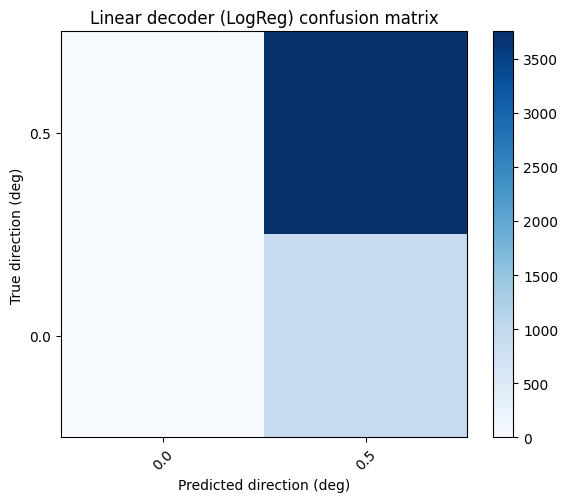

[Linear Rate] train acc = 0.8005, test acc = 0.8005
Epoch   1 | loss 0.5051 | train acc 0.8128 | test acc 0.8118
Epoch   5 | loss 0.4711 | train acc 0.8158 | test acc 0.8129
Epoch  10 | loss 0.4627 | train acc 0.8172 | test acc 0.8144
Epoch  15 | loss 0.4571 | train acc 0.8174 | test acc 0.8144
Epoch  20 | loss 0.4524 | train acc 0.8190 | test acc 0.8108
Epoch  25 | loss 0.4471 | train acc 0.8207 | test acc 0.8129
Epoch  30 | loss 0.4433 | train acc 0.8213 | test acc 0.8110
Epoch  35 | loss 0.4379 | train acc 0.8215 | test acc 0.8116
Epoch  40 | loss 0.4328 | train acc 0.8253 | test acc 0.8067
Final MLP test accuracy: 0.8066993812673352
[MLP Rate]   test acc = 0.8067
Epoch   1 | loss 0.5438 | train acc 0.8001 | test acc 0.8009
Epoch   5 | loss 0.4934 | train acc 0.8122 | test acc 0.8129
Epoch  10 | loss 0.4864 | train acc 0.8146 | test acc 0.8133
Epoch  15 | loss 0.4791 | train acc 0.8156 | test acc 0.8144
Epoch  20 | loss 0.4756 | train acc 0.8152 | test acc 0.8148
Epoch  25 | loss 0.

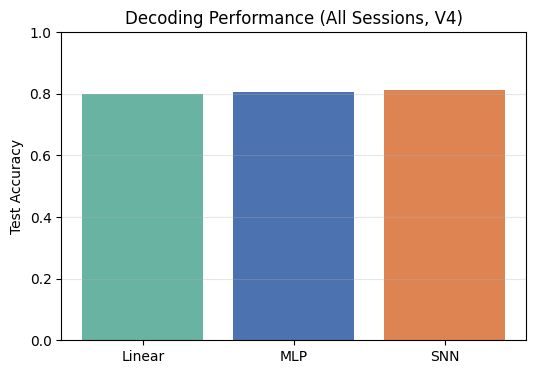

In [ ]:
# ==== 实验：使用 HenryKohn2022_distractororientation_all_sessions_v4.npz ====

import os
import numpy as np
import matplotlib.pyplot as plt

from decoding.linear_decoder import train_and_eval_linear
from decoding.rate_decoder_mlp import train_rate_mlp
from decoding.snn_decoder import train_snn_decoder

# ---------- 配置 ----------
npz_path = r"D:\Neuron Science\FinPro\npz_data\HenryKohn2022_distractorseparation_all_sessions_v4.npz"
npz_noisy_path = r"D:\Neuron Science\FinPro\npz_data\HenryKohn2022_distractororientation_all_sessions_v4_noisy.npz"
test_size = 0.2
random_state = 0
mlp_epochs = 40
snn_epochs = 40

print("加载大数据集：", npz_path)


# ========== Linear baseline ==========
lin_model, (train_acc_lin, test_acc_lin) = train_and_eval_linear(
    dataset_path=npz_path,
    test_size=test_size,
    random_state=random_state,
)
print(f"[Linear Rate] train acc = {train_acc_lin:.4f}, test acc = {test_acc_lin:.4f}")


# ========== MLP rate decoder ==========
mlp_model, (test_acc_mlp, mlp_history) = train_rate_mlp(
    dataset_path=npz_path,
    test_size=test_size,
    random_state=random_state,
    n_epochs=mlp_epochs,
)
print(f"[MLP Rate]   test acc = {test_acc_mlp:.4f}")


# ========== SNN decoder ==========
snn_model, (test_acc_snn, snn_history) = train_snn_decoder(
    dataset_path=npz_path,
    test_size=test_size,
    random_state=random_state,
    n_epochs=snn_epochs,
)
print(f"[SNN Spike]  test acc = {test_acc_snn:.4f}")


# ---------- 展示结果 ----------
print("\n=== Summary ===")
print(f"Linear : {test_acc_lin:.4f}")
print(f"MLP    : {test_acc_mlp:.4f}")
print(f"SNN    : {test_acc_snn:.4f}")

plt.figure(figsize=(6,4))
plt.bar(["Linear","MLP","SNN"],
        [test_acc_lin, test_acc_mlp, test_acc_snn],
        color=["#69b3a2","#4c72b0","#dd8452"])
plt.ylabel("Test Accuracy")
plt.title("Decoding Performance (All Sessions, V4)")
plt.ylim(0, 1.0)
plt.grid(axis="y", alpha=0.3)
plt.show()





In [20]:
#打印HenryKohn2022_distractororientation_all_sessions_v4.npz数据集中的内容
data = np.load(npz_path, allow_pickle=True)
print("数据集包含的键：", data.files)   
for key in data.files:
    print(f"\n键: {key}")
    print("内容:", data[key])
    print("形状:", data[key].shape if hasattr(data[key], 'shape') else 'N/A')
    print("数据类型:", data[key].dtype if hasattr(data[key], 'dtype') else  'N/A')
    

数据集包含的键： ['spikes', 'spikecounts', 'labels', 'directions_deg', 'session_idx', 'meta']

键: spikes
内容: [[[0.08 0.1  0.06 ... 0.04 0.14 0.04]
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]
  ...
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]]

 [[0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  ...
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]]

 [[0.14 0.14 0.08 ... 0.18 0.08 0.14]
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]
  ...
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]]

 ...

 [[0.06 0.02 0.3  ... 0.18 0.   0.12]
  [0.06 0.02 0.3  ... 0.18 0.   0.12]
  [0.06 0.02 0.3  ... 0.18 0.   0.12]
  ...
  [0.06 0.02 0.3  ... 0.18 0.   0.12]
  [0.06 0.02 0.3  ... 0.18 

In [24]:
import scipy.io as sio

mat_path = "D:\\Neuron Science\\FinPro\\mat_data\\HenryKohn2022_distractororientation.mat"   # 改成你的文件路径

data = sio.loadmat(mat_path)

# 打印所有变量名和内容
for key, value in data.items():
    if key.startswith("__"):   # 跳过系统变量
        continue
    print(f"== {key} ==")
    print(value)
    print()



== v1population ==
[[(array([[1]], dtype=uint8), array(['AL'], dtype='<U2'), array([[  0.5,   0.5,   0.5, ...,   0.5,   0.5,   0.5],
         [-12. ,   8. ,  -8. , ...,   8. ,  12. ,  -8. ],
         [  0.5,   0.5,   0. , ...,   0. ,   0.5,   0. ],
         ...,
         [-10. , -10. ,   0. , ...,   0. , -10. ,   0. ],
         [ 10. ,  10. ,   0. , ...,   0. ,  10. ,   0. ],
         [-10. , -10. ,   0. , ...,   0. , -10. ,   0. ]], shape=(7, 1100)), array([[array(['target contrast'], dtype='<U15')],
         [array(['target ori'], dtype='<U10')],
         [array(['distractor contrast'], dtype='<U19')],
         [array(['distractor1 ori'], dtype='<U15')],
         [array(['distractor2 ori'], dtype='<U15')],
         [array(['distractor3 ori'], dtype='<U15')],
         [array(['distractor4 ori'], dtype='<U15')]], dtype=object), array([[1]], dtype=uint8), array([[ 6,  4,  5, ...,  4,  2,  1],
         [ 2,  0,  2, ...,  4,  1,  2],
         [ 9,  7,  8, ...,  4,  4,  2],
         ...,
 

spikes: (9332, 50, 23)
labels: (9332,)
directions_deg: [0.  0.5]
Preferred directions per neuron (deg): [0.5 0.5 0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5] ...


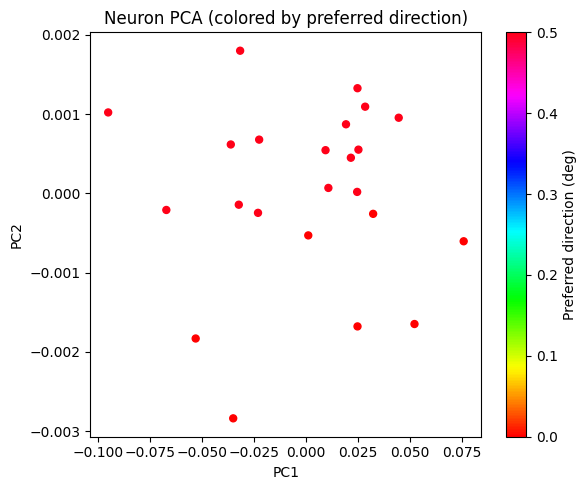

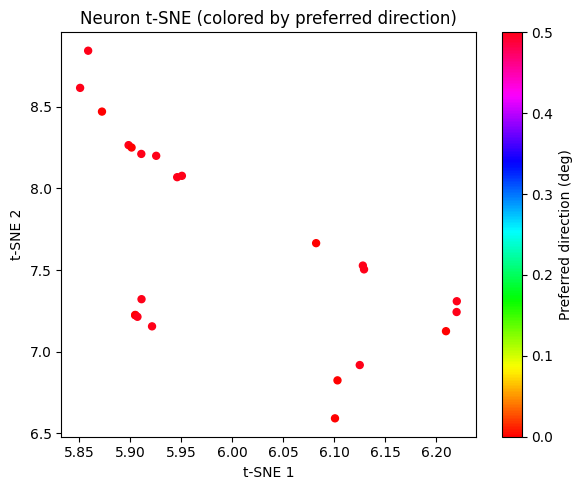

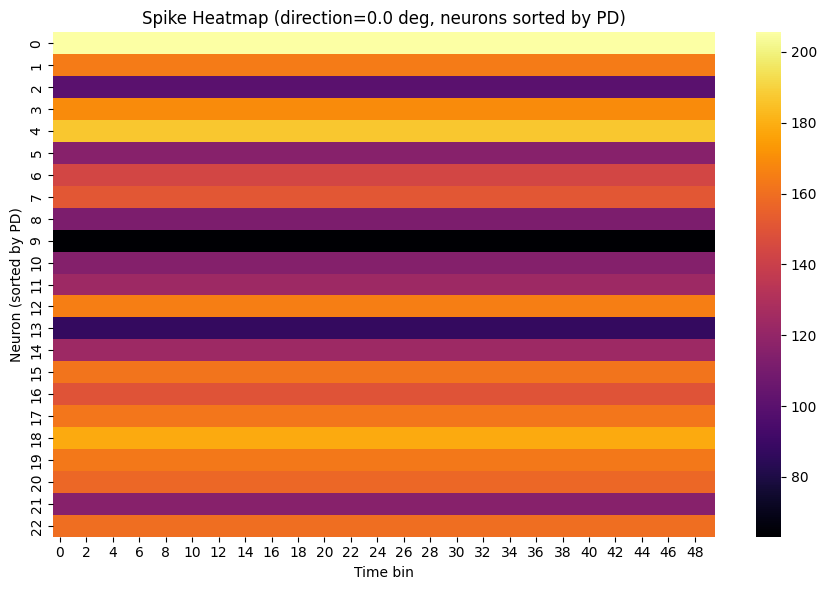

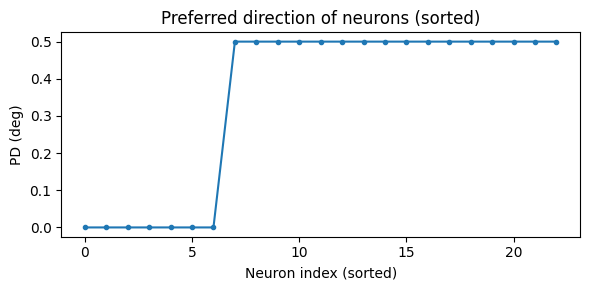

T_epoch_ms = 250.0 dt_ms = 5.0


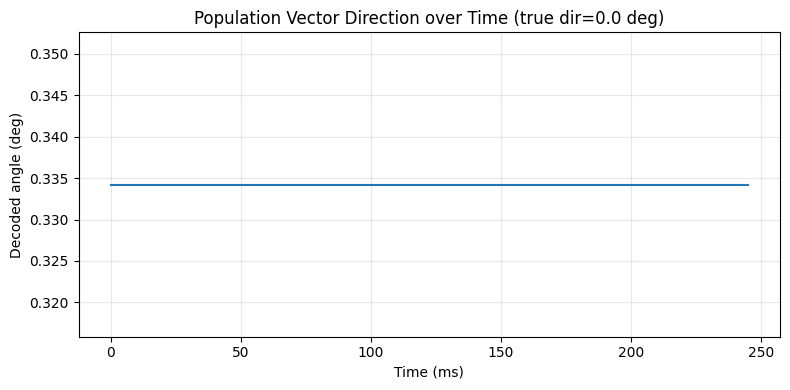

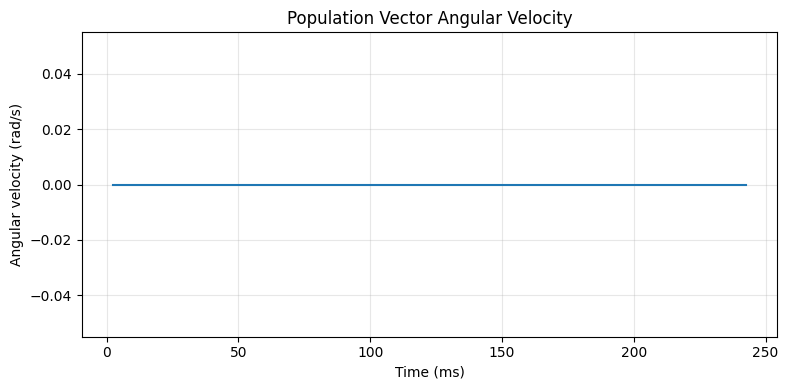

In [4]:
# ==============================================
# Neuron population analysis & visualization
# ==============================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --------------------------
# 0. 加载数据
# --------------------------
npz_path = r"D:\Neuron Science\FinPro\npz_data\HenryKohn2022_distractororientation_all_sessions_v4.npz"
data = np.load(npz_path, allow_pickle=True)

spikes = data["spikes"]             # (N_trials, T_steps, N_neurons)
labels = data["labels"]             # (N_trials,)
directions_deg = data["directions_deg"]  # (n_dirs,)
meta = data["meta"][0]
print("spikes:", spikes.shape)
print("labels:", labels.shape)
print("directions_deg:", directions_deg)

N_trials, T_steps, N_neurons = spikes.shape
n_dirs = len(directions_deg)

# ==============================================
# 1. 估计每个 neuron 的 tuning & preferred direction
# ==============================================
# tuning_matrix: (n_dirs, N_neurons) = 每个方向下，各 neuron 的平均 firing (trial+time 平均)
tuning_matrix = np.zeros((n_dirs, N_neurons), dtype=float)

for d_idx, theta in enumerate(directions_deg):
    # 这里假定 labels 是方向索引 0..n_dirs-1，对应 directions_deg 的 index
    trial_mask = (labels == d_idx)
    if np.sum(trial_mask) == 0:
        continue
    # 选出该方向的所有 trial，对时间+trial做平均
    # spikes[trial_mask] : (n_trials_d, T_steps, N_neurons)
    tuning_matrix[d_idx] = spikes[trial_mask].mean(axis=(0, 1))

# 每个 neuron 的 PD = 让它响应最大的方向
preferred_dir_idx = np.argmax(tuning_matrix, axis=0)   # (N_neurons,)
preferred_dir_deg = directions_deg[preferred_dir_idx]  # (N_neurons,)

# 简单计算一个 tuning 强度指标：max-min 或 max/mean
tuning_max = tuning_matrix.max(axis=0)
tuning_min = tuning_matrix.min(axis=0)
tuning_mean = tuning_matrix.mean(axis=0)
tuning_contrast = tuning_max - tuning_min  # response range
tuning_selectivity = np.where(tuning_mean > 0, tuning_max / (tuning_mean + 1e-6), 0)

print("Preferred directions per neuron (deg):", preferred_dir_deg[:10], "...")


# ==============================================
# 2. 对 neuron 做 PCA / t-SNE 可视化
#    特征选择：用 tuning_matrix 每列代表一个 neuron（每个 neuron 在不同方向的平均响应）
# ==============================================
# neuron_features: (N_neurons, n_dirs)
neuron_features = tuning_matrix.T  # 每一行是一个 neuron 在各方向上的 tuning

# 2.1 PCA
pca = PCA(n_components=2)
neuron_pca = pca.fit_transform(neuron_features)  # (N_neurons, 2)

# 2.2 t-SNE（略慢，视 N_neurons 而定）
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=20.0)
neuron_tsne = tsne.fit_transform(neuron_features)

# 可视化时用 preferred_dir_deg 作为颜色
norm_pd = (preferred_dir_deg - preferred_dir_deg.min()) / (np.ptp(preferred_dir_deg) + 1e-6)


plt.figure(figsize=(6, 5))
plt.scatter(neuron_pca[:, 0], neuron_pca[:, 1],
            c=preferred_dir_deg, cmap="hsv", s=25)
plt.colorbar(label="Preferred direction (deg)")
plt.title("Neuron PCA (colored by preferred direction)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(neuron_tsne[:, 0], neuron_tsne[:, 1],
            c=preferred_dir_deg, cmap="hsv", s=25)
plt.colorbar(label="Preferred direction (deg)")
plt.title("Neuron t-SNE (colored by preferred direction)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


# ==============================================
# 3. 按 preferred direction 排序 neuron，画 raster / heatmap
# ==============================================
# neuron_sorted_idx: 按 preferred_dir_deg 从小到大排序
neuron_sorted_idx = np.argsort(preferred_dir_deg)
sorted_PD = preferred_dir_deg[neuron_sorted_idx]

# 选一个方向（例如 directions_deg[0]）的所有 trial，叠加在一起做一个“伪 raster”
target_dir_idx = 0
dir_mask = (labels == target_dir_idx)
spikes_dir = spikes[dir_mask]   # (n_trials_d, T_steps, N_neurons)
if spikes_dir.shape[0] == 0:
    print("No trials for this direction, try another target_dir_idx.")
else:
    # 汇总：对 trial 求和，得到 (T_steps, N_neurons)
    spikes_dir_sum = spikes_dir.sum(axis=0)  # (T_steps, N_neurons)
    # 按 neuron PD 排序
    spikes_dir_sorted = spikes_dir_sum[:, neuron_sorted_idx]  # (T_steps, N_neurons)

    plt.figure(figsize=(9, 6))
    sns.heatmap(spikes_dir_sorted.T, cmap="inferno", cbar=True)
    plt.title(f"Spike Heatmap (direction={directions_deg[target_dir_idx]} deg, neurons sorted by PD)")
    plt.xlabel("Time bin")
    plt.ylabel("Neuron (sorted by PD)")
    plt.tight_layout()
    plt.show()

    # 可选：附上一条 sorted PD 曲线
    plt.figure(figsize=(6, 3))
    plt.plot(sorted_PD, '.-')
    plt.title("Preferred direction of neurons (sorted)")
    plt.xlabel("Neuron index (sorted)")
    plt.ylabel("PD (deg)")
    plt.tight_layout()
    plt.show()


# ==============================================
# 4. Population vector 解码 + 角速度 (angular velocity)
#    思路：
#    - 用上面估计的 neuron PD 作为编码方向 θ_i
#    - 对某个条件（例如某个真实方向）下，按时间 bin 统计每个 neuron 的发放 r_i(t)
#    - population vector: R(t) = Σ r_i(t) [cos θ_i, sin θ_i]
#    - 解码方向：φ(t) = atan2(Σ r_i sinθ_i, Σ r_i cosθ_i)
#    - 角速度：dφ/dt
# ==============================================

def population_vector_direction(spike_mat, neuron_pd_deg):
    """
    spike_mat: (T_steps, N_neurons) 当前条件下（可已对 trial 求平均或求和）的 firing / spike 数
    neuron_pd_deg: (N_neurons,) 每个 neuron 的 PD（度）
    返回:
        phi_t: (T_steps,) 每个时间点的 population vector 方向（弧度）
    """
    theta_rad = np.deg2rad(neuron_pd_deg)  # (N_neurons,)
    cos_th = np.cos(theta_rad)
    sin_th = np.sin(theta_rad)

    # spike_mat: (T, N)
    # 计算 x(t), y(t)
    x_t = np.dot(spike_mat, cos_th)   # (T,)
    y_t = np.dot(spike_mat, sin_th)   # (T,)

    phi_t = np.arctan2(y_t, x_t)      # (-pi, pi]
    return phi_t

def angular_velocity(phi_t, dt):
    """
    phi_t: (T,) 弧度序列
    dt: 时间步长（秒）
    返回:
        omega: (T-1,) 每个时间段的角速度（弧度/秒）
    """
    # unwrap 避免 2π 跳变
    phi_unwrap = np.unwrap(phi_t)
    dphi = np.diff(phi_unwrap)    # (T-1,)
    omega = dphi / dt
    return omega

# 假设你的 T_epoch_ms / dt_ms 如 meta 中记录
T_epoch_ms = meta.get("T_epoch_ms", 250.0)
dt_ms = meta.get("dt_ms", 5.0)
dt_s = dt_ms / 1000.0
print("T_epoch_ms =", T_epoch_ms, "dt_ms =", dt_ms)

# 我们对某个真实方向（例如 target_dir_idx）下的 trial 做 population vector 解码
if spikes_dir.shape[0] > 0:
    # spikes_dir: (n_trials_d, T_steps, N_neurons)
    # 使用平均 firing（trial 均值）作为 r_i(t)
    spike_mean_tn = spikes_dir.mean(axis=0)   # (T_steps, N_neurons)

    phi_t = population_vector_direction(spike_mean_tn, preferred_dir_deg)  # (T_steps,)
    omega = angular_velocity(phi_t, dt_s)  # (T_steps-1,)

    time_axis = np.arange(T_steps) * dt_ms   # ms
    time_axis_mid = (np.arange(T_steps-1) + 0.5) * dt_ms

    plt.figure(figsize=(8, 4))
    plt.plot(time_axis, np.rad2deg(phi_t))
    plt.title(f"Population Vector Direction over Time (true dir={directions_deg[target_dir_idx]} deg)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Decoded angle (deg)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(time_axis_mid, omega)
    plt.title("Population Vector Angular Velocity")
    plt.xlabel("Time (ms)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No trials for this direction; skip population vector demo.")
